In [83]:
import sys

import mujoco
import mediapy as media
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import numpy as np
import time
import main

with open("leg_parametric.xml", "r") as f:
  xml = f.read()

In [98]:
if 'renderer' in locals():
    del renderer
if 'model' in locals():
    del model
if 'data' in locals():
    del data

timevals = []
angular_velocity = []
force = []
length = []

energy = []
contact = []

frames = []
duration = 50    # (seconds)
framerate = 60  # (Hz)

model = mujoco.MjModel.from_xml_string(xml)
renderer = mujoco.Renderer(model)
data = mujoco.MjData(model)
mujoco.mj_forward(model, data)

actuation_step = 5

# Simulate and save data
mujoco.mj_resetDataKeyframe(model, data, 0)
angles = []
i = 0
while data.time < duration:
  if data.time < 5:
    f = 0
  else:
    f = ((data.time-5)/duration * (actuation_step+1)) / actuation_step
  data.ctrl = [f, 0, 0, 0]
  mujoco.mj_step(model, data)
  
  if data.time >= 5:
    timevals.append(data.time)
    energy.append(data.energy[0] + data.energy[1])
    
    angles.append(data.qpos[0])
    length.append(data.sensordata[0])
    force.append(data.sensordata[1])


  #angle.append(data.qpos[])

  if len(frames) < data.time * framerate:
    #print(data.qfrc_applied)
    renderer.update_scene(data)
    pixels = renderer.render()
    frames.append(pixels)
  i += 1

Energy (potential + kinetic) variation: 0.0
Muscle+Tendon length: (initial, final): (148, 125)
Muscle contraction under max force (-40N): 23mm, or 15%


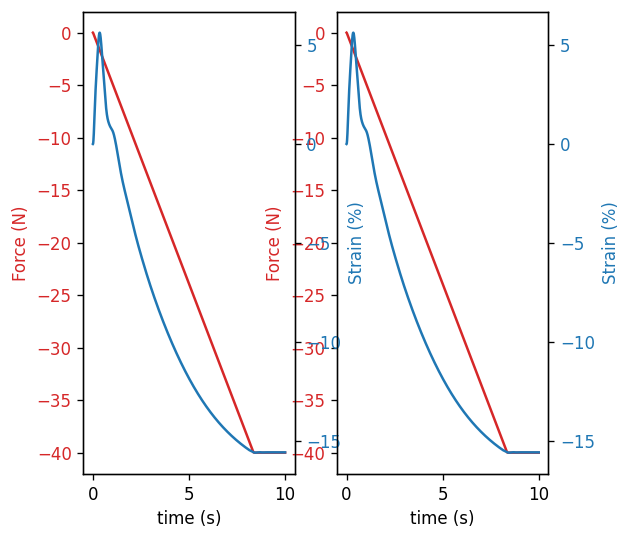

In [68]:
print(f"Energy (potential + kinetic) variation: {np.sum([x**2 for x in energy])}")
print(f"Muscle+Tendon length: (initial, final): {int(length[0]*1000), int(length[-1]*1000)}")
print(f"Muscle contraction under max force ({int(force[-1])}N): {-int((length[-1] - length[0])*1000)}mm, or {-int(100*(length[-1] - length[0])/length[0])}%")
if length[0] != 0:
    contraction = (length - length[0]) / length[0] * 100
dpi = 120
width = 600
height = 600
figsize = (width / dpi, height / dpi)
_, ax = plt.subplots(1, 2, figsize=figsize, dpi=dpi, sharex=True)

color = 'tab:red'
ax[0].plot(timevals, force, label='force', color=color)
ax[0].tick_params(axis='y', labelcolor=color)
ax[0].set_xlabel('time (s)')
ax[0].set_ylabel('Force (N)', color=color)
ax_ = ax[0].twinx()

color = 'tab:blue'
ax_.plot(timevals, contraction, label='contraction', color=color)
ax_.set_ylabel('Strain (%)', color=color)
ax_.tick_params(axis='y', labelcolor=color)

color = 'tab:red'
ax[1].plot(timevals, force, label='force', color=color)
ax[1].tick_params(axis='y', labelcolor=color)
ax[1].set_xlabel('time (s)')
ax[1].set_ylabel('Force (N)', color=color)
ax_ = ax[1].twinx()

color = 'tab:blue'
ax_.plot(timevals, contraction, label='contraction', color=color)
ax_.set_ylabel('Strain (%)', color=color)
ax_.tick_params(axis='y', labelcolor=color)

media.show_video(frames, fps=framerate)

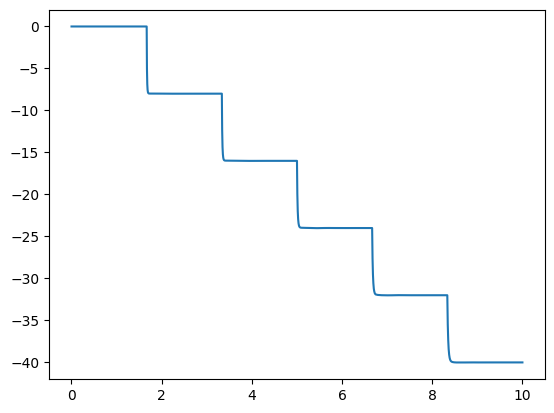

In [34]:
plt.plot(timevals, force)

ValueError: 'y<' is not a valid value for axis; supported values are 'x', 'y', 'both'

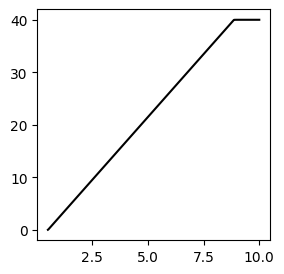

In [96]:
fig, ax0 = plt.subplots(figsize=(3,3))

color = 'black'
fp = ax0.plot(timevals, -np.array(force), label='Actuator tension', color=color)
ax0.tick_params(axis='y<', labelcolor=color)
ax0.set_xlabel('Time [s]', weight='bold')
ax0.set_ylabel('Force [N]', weight='bold', color=color)

ax1 = ax0.twinx()
color = 'grey'
cp = ax1.plot(timevals, [np.rad2deg(angle) for angle in angles], label='Joint angle', color=color)
ax1.set_ylabel('Angle [deg]', weight='bold', color=color)
ax1.tick_params(axis='y', labelcolor=color)

plt.legend(fp+cp, [f.get_label() for f in fp+cp], loc='lower right')
#plt.savefig('force_contraction.eps', format='eps', bbox_inches = 'tight')

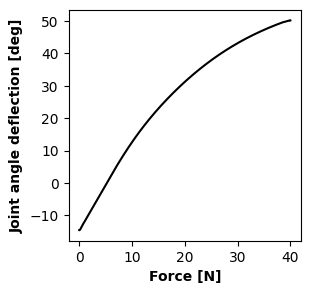

In [102]:
fig, ax0 = plt.subplots(figsize=(3,3))

color = 'black'
ax0.set_ylabel('Joint angle deflection [deg]', weight='bold')
ax0.set_xlabel('Force [N]', weight='bold', color=color)

ax0.plot(-np.array(force), [np.rad2deg(angle) for angle in angles], label='Actuator tension', color=color)
plt.savefig('force_angle.eps', format='eps', bbox_inches = 'tight')
